# Pr√°ctica 2. Clustering de semillas

## 1. Visualizaci√≥n de datos con distintos scalers + PCA

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


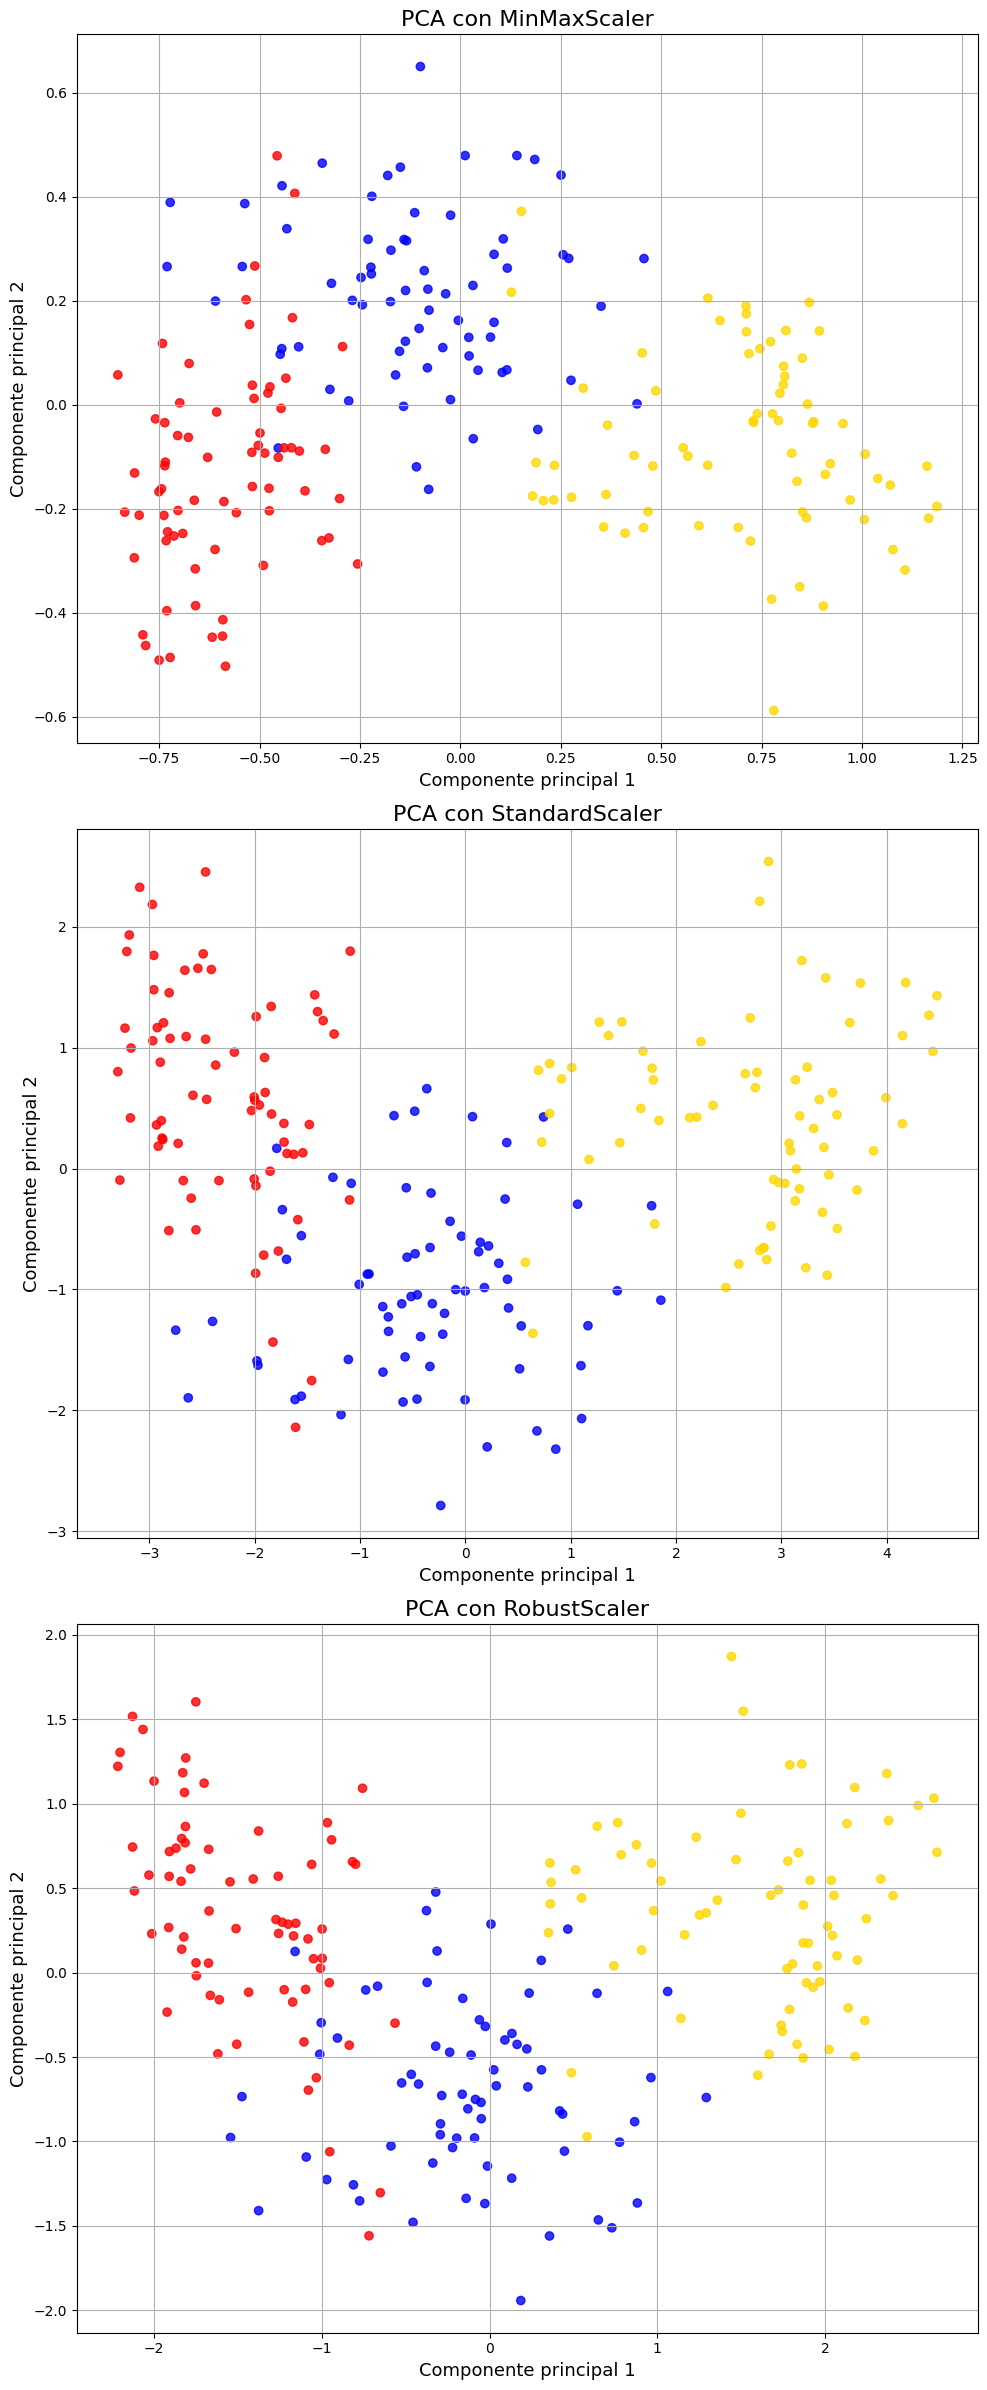

In [27]:
# Cargar datos
df = pd.read_csv("semillas.csv")
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Mapeo de colores personalizados por clase
color_map = {1: 'blue', 2: 'gold', 3: 'red'}
colors = y.map(color_map)

# Definir los escaladores
scalers = {
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler()
}

# Crear figura para mostrar los 3 gr√°ficos verticalmente
fig, axes = plt.subplots(3, 1, figsize=(10, 24))  # 10 de ancho, 24 de alto

for ax, (scaler_name, scaler) in zip(axes, scalers.items()):
    pipeline = Pipeline([
        ("scaler", scaler),
        ("pca", PCA(n_components=2))
    ])
    X_pca = pipeline.fit_transform(X)

    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.8)
    ax.set_title(f"PCA con {scaler_name}", fontsize=16)
    ax.set_xlabel("Componente principal 1", fontsize=13)
    ax.set_ylabel("Componente principal 2", fontsize=13)
    ax.grid(True)

plt.tight_layout()
plt.show()

### Comparativa de escaladores tras PCA 

Se ha aplicado PCA a los datos de semillas tras escalar con tres m√©todos distintos: **MinMaxScaler**, **StandardScaler** y **RobustScaler**. En cada caso se proyectan las instancias sobre los dos primeros componentes principales.

Los puntos est√°n coloreados seg√∫n la clase real de semilla:
- üîµ Clase 1
- üü° Clase 2
- üî¥ Clase 3

#### Observaciones:
- **MinMaxScaler** ofrece una separaci√≥n aceptable, especialmente entre las clases 2 (amarillo) y 3 (rojo), aunque con algo m√°s de solapamiento en el centro.
- **StandardScaler** proporciona una separaci√≥n **muy clara entre las tres clases**, con fronteras bastante definidas entre cada grupo. Las clases se distribuyen mejor en el plano de componentes.
- **RobustScaler** tambi√©n consigue una separaci√≥n razonable, aunque los grupos no se distinguen tanto como con StandardScaler. Aun as√≠, es robusto ante valores extremos.

#### Conclusi√≥n:
**StandardScaler** es el m√©todo de escalado que mejor preserva la estructura de clases del conjunto de datos original, facilitando una posible tarea de clustering. Por ello, se utilizar√° como preprocesamiento base en los siguientes apartados.


## 2. T√©cnicas de Clustering
Usamos X_2d aplicar los algoritmos de clustering: KMeans, jer√°rquico y DBSCAN, y visualizar los resultados de los clusters en un gr√°fico bidimensional

In [28]:
# Separar caracter√≠sticas (sin la clase)
X = df.iloc[:, :-1]

# Aplicar escalado y reducci√≥n a 2 dimensiones
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

### M√©todo del codo y silhoutte (KMeans)

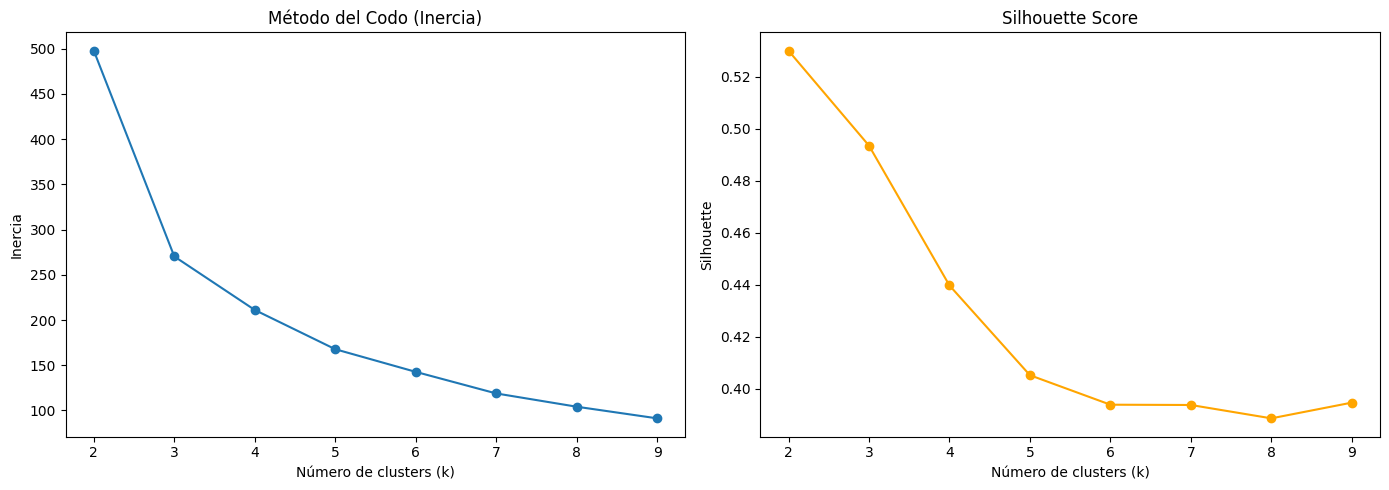

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
silhouette = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42)
    kmeans.fit(X_2d)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_2d, kmeans.labels_))

# Gr√°ficos de evaluaci√≥n
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow
ax[0].plot(K_range, inertia, marker='o')
ax[0].set_title("M√©todo del Codo (Inercia)")
ax[0].set_xlabel("N√∫mero de clusters (k)")
ax[0].set_ylabel("Inercia")

# Silhouette
ax[1].plot(K_range, silhouette, marker='o', color='orange')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("N√∫mero de clusters (k)")
ax[1].set_ylabel("Silhouette")

plt.tight_layout()
plt.show()

- **M√©todo del Codo**: La inercia decrece al aumentar k, pero el cambio m√°s significativo parece estar en k = 3, lo cual sugiere que podr√≠a ser un buen n√∫mero de clusters.

-  **Silhouette Score**: El valor tambi√©n es m√°s alto para k = 3, lo que confirma que 3 es una buena elecci√≥n, ya que indica mejor separaci√≥n entre clusters.

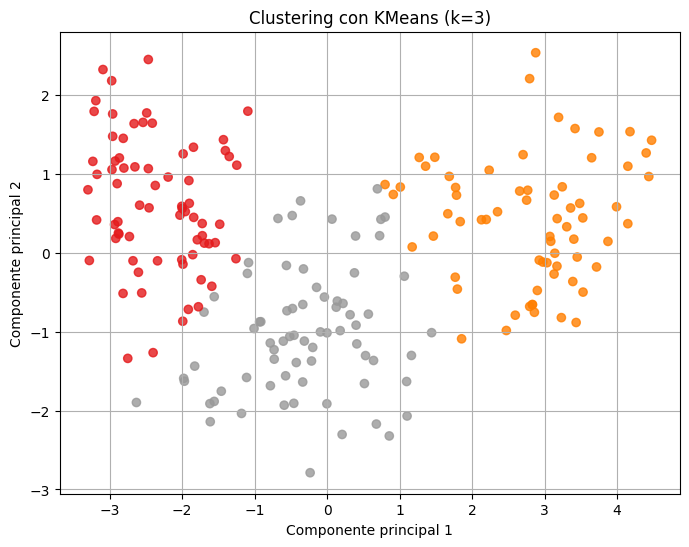

In [30]:
# Aplicar KMeans con k=3
kmeans_final = KMeans(n_clusters=3, n_init=25, random_state=42)
labels_kmeans = kmeans_final.fit_predict(X_2d)

# Visualizar los clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmeans, cmap="Set1", alpha=0.8)
plt.title("Clustering con KMeans (k=3)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()

## M√©todo Hierarchical Clustering / Dendrogramas

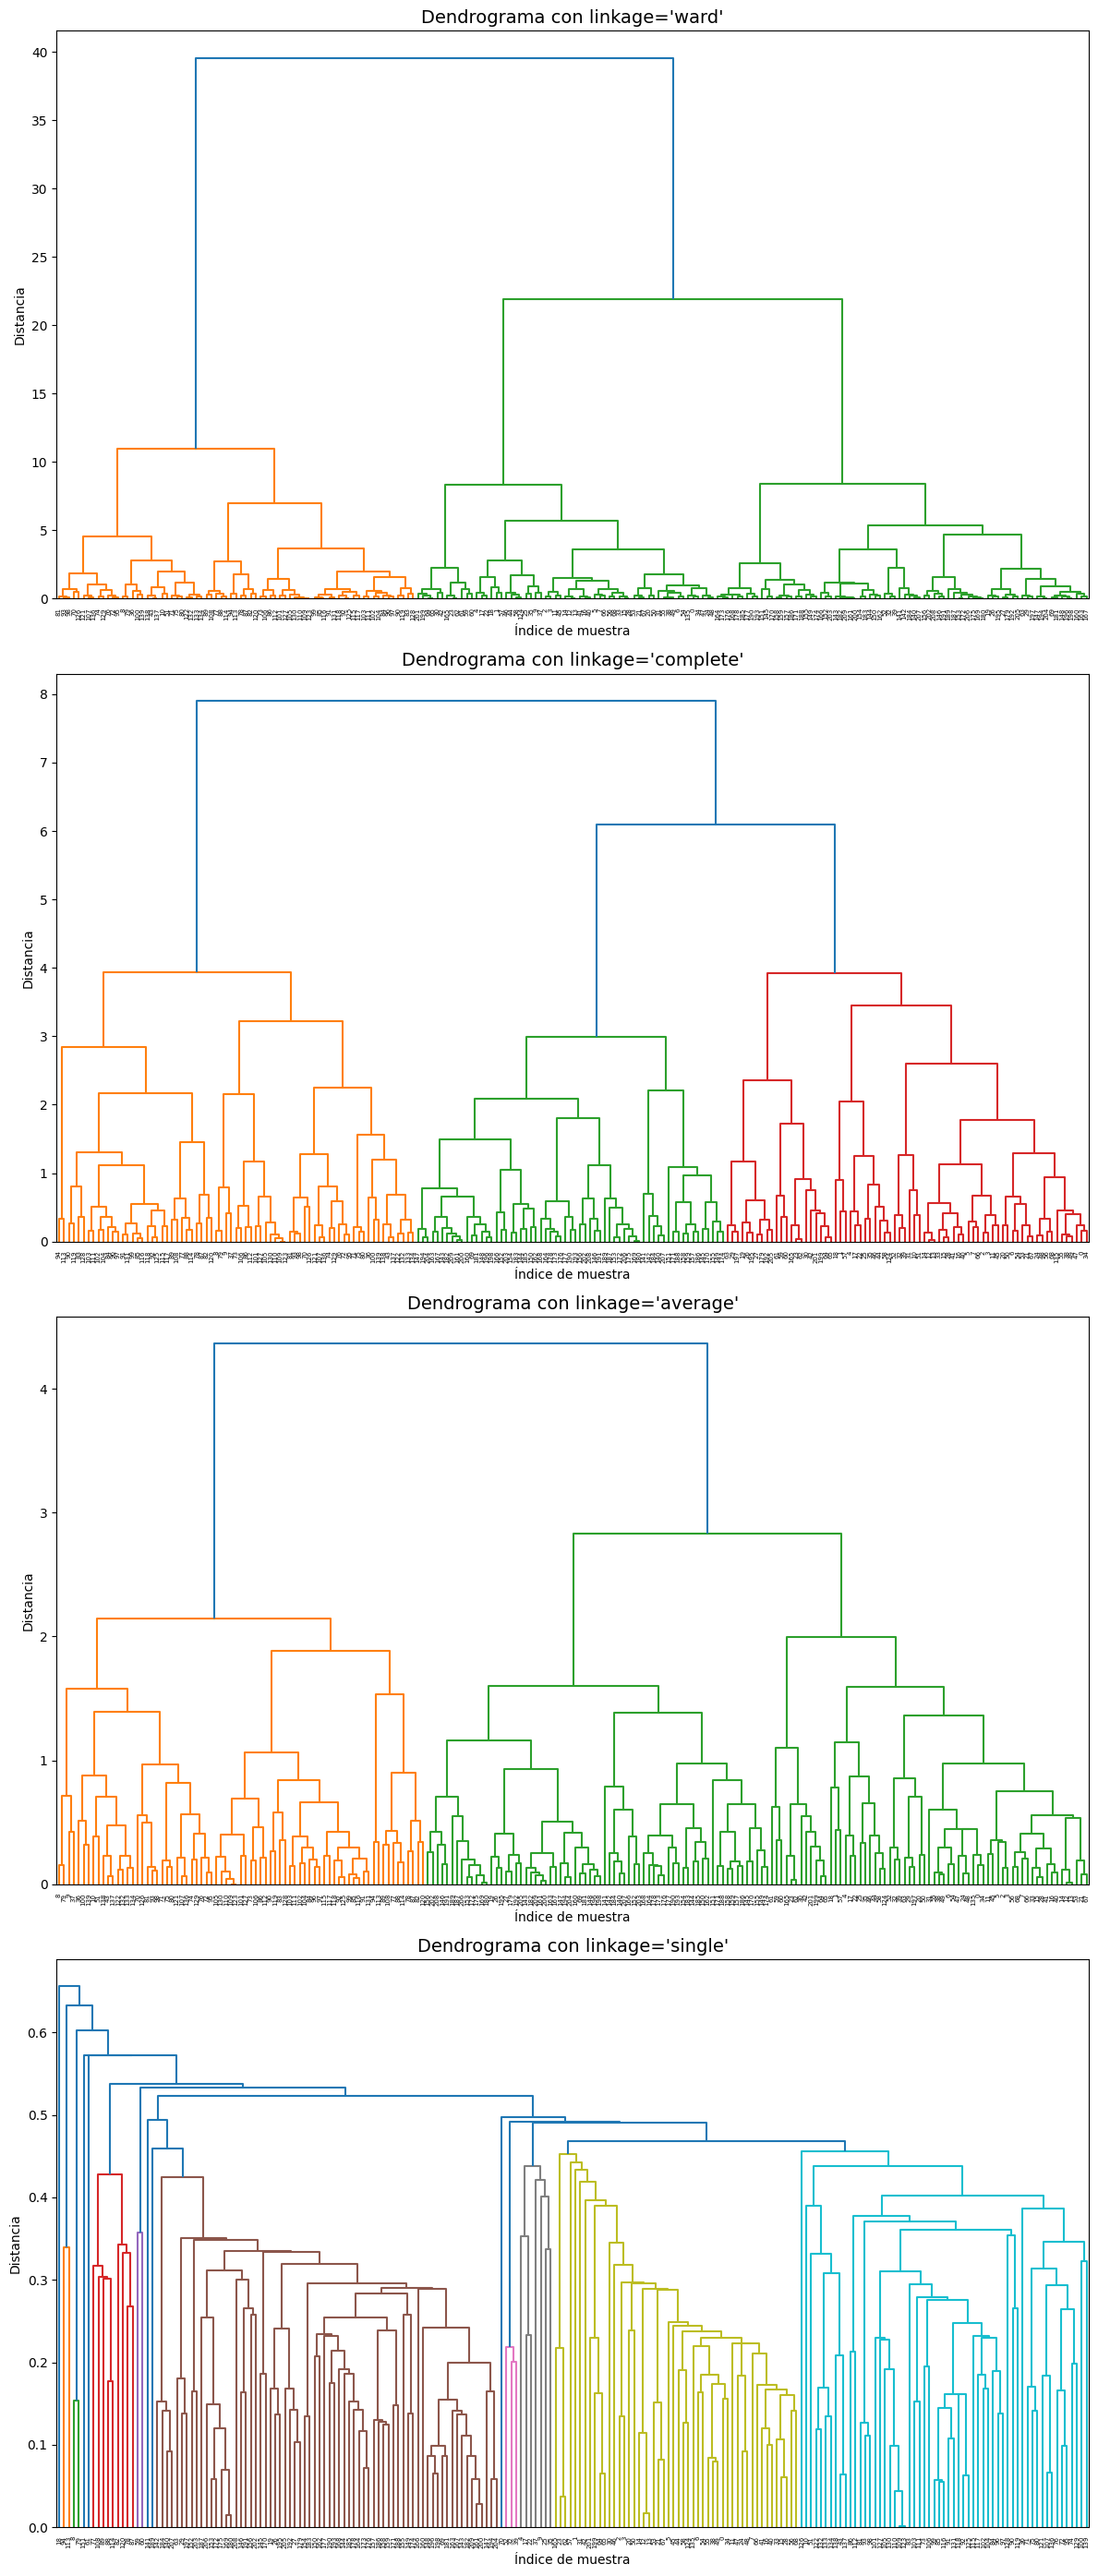

In [31]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# M√©todos de linkage a probar
linkage_methods = ["ward", "complete", "average", "single"]

# Dibujar un dendrograma para cada tipo de linkage
fig, axes = plt.subplots(len(linkage_methods), 1, figsize=(12, 28))

for ax, method in zip(axes, linkage_methods):
    Z = linkage(X_2d, method=method)
    dendrogram(Z, ax=ax)
    ax.set_title(f"Dendrograma con linkage='{method}'", fontsize=14)
    ax.set_xlabel("√çndice de muestra")
    ax.set_ylabel("Distancia")

plt.tight_layout()
plt.show()

**ward**: muestra una separaci√≥n muy clara en 3 grandes bloques, ideal para este problema. Es el m√°s recomendado si trabajas con distancias eucl√≠deas.

**complete** y **average**: tambi√©n muestran una separaci√≥n en 3 o 4 grupos razonables.

**single**: crea una estructura m√°s encadenada (efecto cadena), lo que suele generar malos resultados en clustering ‚Äî no es recomendable en este caso.

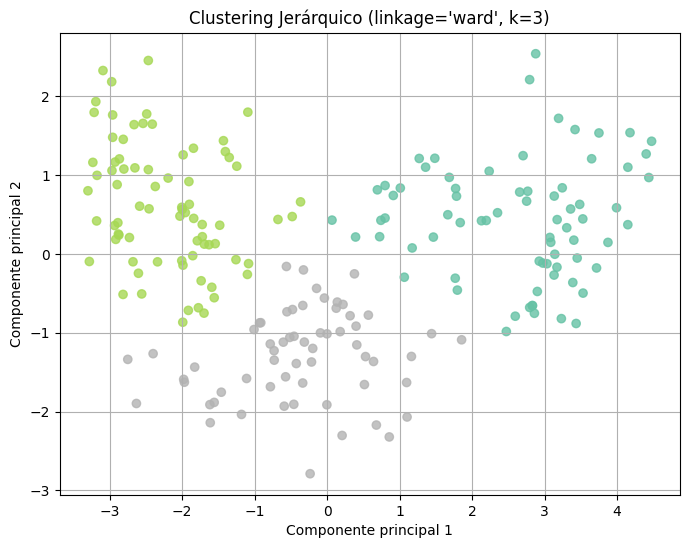

In [32]:
from sklearn.cluster import AgglomerativeClustering

# Aplicar clustering jer√°rquico con linkage 'ward' y 3 clusters
agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agglo = agglo.fit_predict(X_2d)

# Visualizar los clusters jer√°rquicos
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_agglo, cmap="Set2", alpha=0.8)
plt.title("Clustering Jer√°rquico (linkage='ward', k=3)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()


Este resultado del clustering jer√°rquico con ward y k=3 se ve muy limpio y estructurado:

    Los tres grupos est√°n bien separados visualmente.

    No parece haber solapamientos importantes entre los clusters.

    Es un gran punto de comparaci√≥n contra KMeans.

## M√©todo DBSCAN

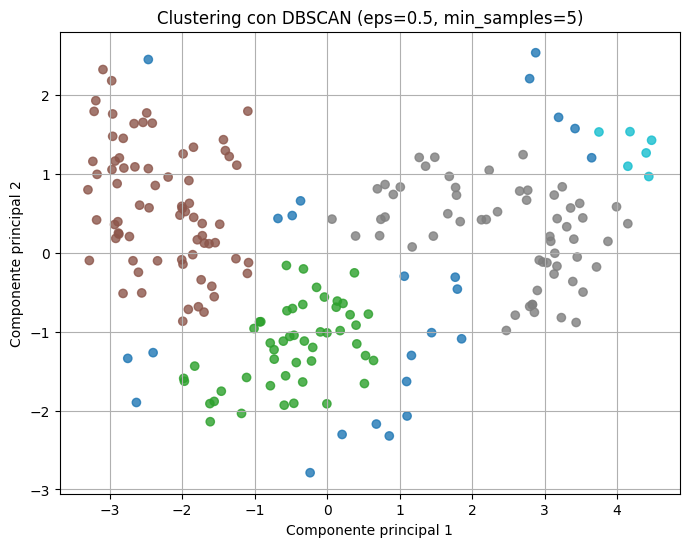

In [33]:
from sklearn.cluster import DBSCAN

# Aplicar DBSCAN con valores iniciales
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_2d)

# Visualizar el resultado de DBSCAN
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_dbscan, cmap="tab10", alpha=0.8)
plt.title("Clustering con DBSCAN (eps=0.5, min_samples=5)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()


DBSCAN ha identificado m√°s de 3 clusters, y probablemente algunos puntos como ruido (label = -1), que aparecen con un color distinto o m√°s tenue.
Algunos grupos est√°n razonablemente bien formados, pero otros parecen fragmentados, lo que sugiere que los valores por defecto podr√≠an no ser ideales.

Toca ajustar los hiperpar√°metros:
- eps (radio de vecindad): prueba valores entre 0.3 y 0.8.

- min_samples (m√≠nimo de vecinos para formar un n√∫cleo): normalmente entre 3 y 10.